# Question 1

In this question we will:

- Design and implement a feature that can be used to creates a feature map sensitive to "greenness".
- Utilize thresholding techniques of this "greenness" feature to obtain a segmentation of green leaves in images with a cluttered background.
- Implement evaluation metrics to measure the quality of a segmentation produced by the thresholding
- Use the metrics to evaluate the segmentation algoirthm's perormance on a dataset of images of green leaves on a cluttered background.

# Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding.  Determine a metric that can be used to meaure the "greenness" of the colour of a given pixel.  Your algoirthm should create a "feature map" by computing this feature for each pixel, thus creating an "image" where each pixel's "intensity" is the value of the "greenness" feature.   Then use a thresholding method of your choice to segment the image's green regions.    You should also consider whether doing some region processing after segmentation can improve the results.  This function should return the segmenetion of the image as a binary image with a single connected component since you can take advantage of the fact that each image is known to contain only a single leaf.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


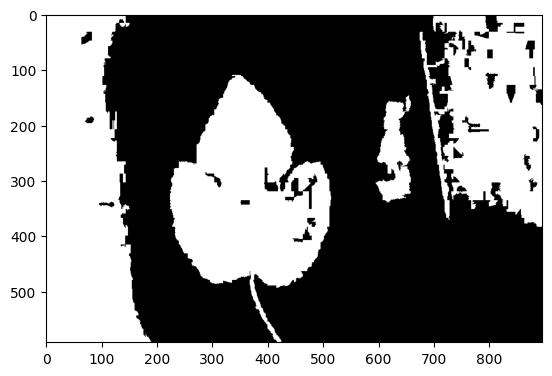

In [317]:
import skimage.util as util
import skimage.io as io
import numpy as np
import os as os
import matplotlib.pyplot as plt
import skimage.filters as filt
import skimage.color as skcolor
import skimage.morphology as morph
import skimage.segmentation as seg
import skimage.measure as meas
# You can import other modules as needed.

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    
    I = util.img_as_float(I)
    I_R, I_G, I_B = I[:, :, 0], I[:, :, 1], I[:, :, 2]
    
    greenness = 2 * I_G - I_R - I_B
    green_mask = (I_G > I_R * 0.9) & (I_G > I_B * 0.9) # purple cells gave me too much stress 
    greenness = np.where(green_mask, greenness, -np.inf) 
    
    thresh_green = filt.threshold_otsu(greenness[green_mask])
    
    binary = greenness > thresh_green
    binary = morph.remove_small_holes(binary, area_threshold=128) 
    binary = morph.remove_small_objects(binary, min_size= 512)

    return binary

print(segleaf(io.imread("/u1/cmpt487-819/data/asn3/images/image_0099.png")))

plt.imshow(segleaf(io.imread("/u1/cmpt487-819/data/asn3/images/image_0099.png")),cmap= 'gray')


# Step 2: Implement Segmentation Performace Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [208]:
from scipy.spatial.distance import cdist

def get_boundaries(binary_image):
   
    labeled_image = morph.label(binary_image > 0)
    bp = np.where(seg.find_boundaries(labeled_image, connectivity=2, mode='inner') > 0)
    boundary_points = np.transpose(np.vstack(bp))
    return boundary_points

def compute_DSC(image, true_image):
    true_image = true_image > 0
    intersection = np.logical_and(image, true_image).sum()
    union = image.sum() + true_image.sum()
    return 2 * intersection / union

def compute_MSD(image, true_image):
    true_image = true_image > 0
    boundary_image = get_boundaries(image)
    boundary_true_image = get_boundaries(true_image)

    distances = cdist(boundary_image, boundary_true_image)
    min_distances = np.min(distances, axis=1)
    msd = np.sum(min_distances**2) / len(boundary_image)
    return msd

def compute_HD(image, true_image):
    true_image = true_image > 0
    boundary_image = get_boundaries(image)
    boundary_true_image = get_boundaries(true_image)
    
    distances_1_to_2 = np.min(cdist(boundary_image, boundary_true_image), axis=1)
    distances_2_to_1 = np.min(cdist(boundary_true_image, boundary_image), axis=1)
    return max(np.max(distances_1_to_2), np.max(distances_2_to_1))


0.8485492657755103
20080.62920984456
345.9393010341554


# Step 3: Write a Validation driver program.

Write code that segments each image (using the function in Step 1), and computes the MSD, HD, and DSC for each segmentation (using the functions in Step 2).  Print the MSD, HD, and DSC of each segmentation to the console as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD, and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image:

* load the image and it's ground truth (use the provided leaf image dataset, described in section 2.2. of the assignment PDF) -- a .csv file is provided with the names of all images so that you can process the files in the same manner as Assignment 1, question 1)
* segment the input image using your function from Step 1
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture notes Topic 6, slide 68 for an example on how to do this).
* Compute the MSD and the HD from the two sets of boundary points (using the appropriate functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the appropriate function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished processing each image, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [318]:
import os
import pandas as pd

images_path = '/u1/cmpt487-819/data/asn3/images/'
gt_path = '/u1/cmpt487-819/data/asn3/groundtruth/'

files = pd.read_csv("/u1/cmpt487-819/data/asn3/images.csv", header=None)
file_list = files[0].tolist()

msd_list = []
hd_list = []
dsc_list = []
recognized_count = 0
total_images = 0


for filename in file_list:

    image_path = os.path.join(images_path, filename)
    gt_image_path = os.path.join(gt_path, filename)
    
    image = io.imread(image_path)
    ground_truth = io.imread(gt_image_path)
    
    segmented_image = segleaf(image)
    
    msd = compute_MSD(segmented_image, ground_truth)
    hd = compute_HD(segmented_image, ground_truth)
    dsc = compute_DSC(segmented_image, ground_truth)
    
    print(f"DSC for {filename}: {dsc}")
    print(f"MSD for {filename}: {msd}")
    print(f"HD for {filename}: {hd}")
    print("-" * 50)
    
    msd_list.append(msd)
    hd_list.append(hd)
    dsc_list.append(dsc)

    if dsc > 0.6:
        recognized_count += 1
    total_images += 1

mean_dsc = np.mean(dsc_list)
std_dsc = np.std(dsc_list)
mean_msd = np.mean(msd_list)
std_msd = np.std(msd_list)
mean_hd = np.mean(hd_list)
std_hd = np.std(hd_list)
recognition_percentage = (recognized_count / total_images) * 100

print("----------------------------------------------------")
print(f"The mean Dice coefficient was: {mean_dsc}")
print(f"The std. deviation of Dice coefficient was: {std_dsc}")
print(f"The mean MSD was: {mean_msd}")
print(f"The std. deviation of MSD was: {std_msd}")
print(f"The mean HD was: {mean_hd}")
print(f"The std. deviation of HD was: {std_hd}")
print(f"{recognition_percentage}% of leaves were recognized.")
print("recognized_count is ", recognized_count)
print("total_images is ", total_images)

DSC for image_0001.png: 0.9850917805625029
MSD for image_0001.png: 961.1501035196687
HD for image_0001.png: 146.81280598094978
--------------------------------------------------
DSC for image_0002.png: 0.9809483206544185
MSD for image_0002.png: 6.966447595987548
HD for image_0002.png: 26.40075756488817
--------------------------------------------------
DSC for image_0005.png: 0.985176669893514
MSD for image_0005.png: 447.88816689466483
HD for image_0005.png: 116.43023662262307
--------------------------------------------------
DSC for image_0007.png: 0.9870713884204609
MSD for image_0007.png: 523.9888579387186
HD for image_0007.png: 121.82364302548172
--------------------------------------------------
DSC for image_0009.png: 0.9658633546507321
MSD for image_0009.png: 3201.4369700395705
HD for image_0009.png: 170.66048165876012
--------------------------------------------------
DSC for image_0010.png: 0.9843643779741672
MSD for image_0010.png: 2106.8482827609205
HD for image_0010.png: 2

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


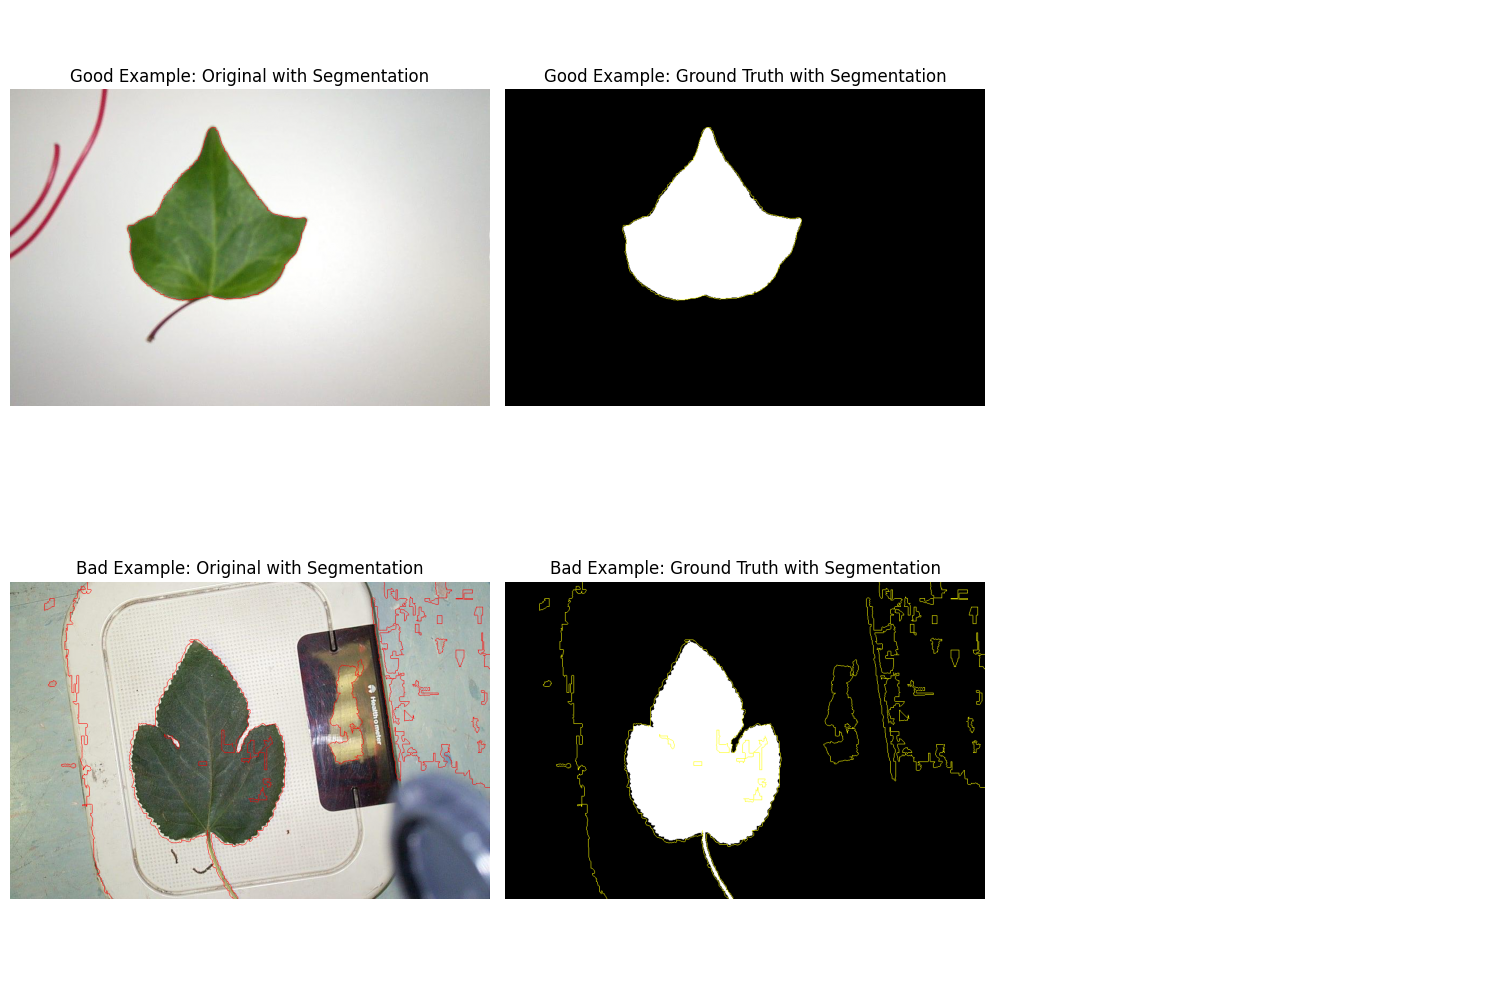

In [323]:
import matplotlib.pyplot as plt

%matplotlib inline

good_example = 'image_0165.png'
bad_example = 'image_0099.png'

images_path = '/u1/cmpt487-819/data/asn3/images/'
gt_path = '/u1/cmpt487-819/data/asn3/groundtruth/'


def get_segmented_image_with_boundaries(image_file):

    image = io.imread(images_path + image_file)
    ground_truth = io.imread(gt_path + image_file)
    
    segmented_image = segleaf(image)
    
    labeled_segmentation = morph.label(segmented_image)
    image_with_boundaries = seg.mark_boundaries(image, labeled_segmentation, color=(1, 0, 0))
    
    ground_truth_with_boundaries = seg.mark_boundaries(ground_truth, labeled_segmentation, color=(1, 1, 0))
    
    return image_with_boundaries, ground_truth_with_boundaries

good_image_with_seg, good_gt_with_seg = get_segmented_image_with_boundaries(good_example)
bad_image_with_seg, bad_gt_with_seg = get_segmented_image_with_boundaries(bad_example)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(good_image_with_seg)
plt.title("Good Example: Original with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(good_gt_with_seg, cmap='gray')
plt.title("Good Example: Ground Truth with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(bad_image_with_seg)
plt.title("Bad Example: Original with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(bad_gt_with_seg, cmap='gray')
plt.title("Bad Example: Ground Truth with Segmentation")
plt.axis('off')

# Empty subplots (optional)
plt.subplot(2, 3, 3)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_ My algorithm first loads the image as float, then divides itself into its subsequent channels, then to extract the greenness i used a formula that removes red and blue intensities however some it gives a negative value when there are purple pixels because then green is compratively very low w.r.t blue and red and here i used ot method to mitigate this, further i obatined the threshold value and obtained the binary image and then removed small holes and objects  and finally return the binary image.

2. Consider your example "good" result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  The algorithm performs fairly good on "good" example image as the dsc score suggests, the score varies probably because of deviation in some boundary points which could be fixed by making some parametric adjustments to get_boundaries function or even paying more attention to shape and boundary descriptors in segleaf funcion.

3. Consider your example "bad" result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  The algorithm is not able to properly segment out other green areas like in image_0165.png , which is because of lack of shape and region description in segleaf fucntion , i was trying to play with regionprops() however i would need some more time properly incorporate those features so that i could remove other green structures that do not resemble a leaf
